# Spike-based Visualization Demo

This notebook demonstrates how the trained CNN and SNN behave on a single keyword example.

It:
- Loads the saved CNN and SNN models.
- Loads one example waveform from the Speech Commands dataset.
- Computes MFCC features and passes them through the CNN and SNN.
- Visualizes waveform, MFCC, and SNN spiking activity over time.

In [1]:
# Cell 1: Imports and paths
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

import torchaudio
import torchaudio.transforms as T
import snntorch as snn
from snntorch import surrogate

PROJECT_ROOT = Path.cwd().resolve()
DATA_ROOT = PROJECT_ROOT / "sample_data" / "speech_commands_v0.02"
MODEL_DIR = PROJECT_ROOT / "saved_models"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT exists:", DATA_ROOT.exists())
print("MODEL_DIR exists:", MODEL_DIR.exists())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CLASSES = ["yes", "no", "go", "stop", "down", "up"]
SAMPLE_RATE = 16000
N_MFCC = 40

PROJECT_ROOT: /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project_backup
DATA_ROOT exists: True
MODEL_DIR exists: True
Using device: cpu


In [2]:
# Cell 2: Model definitions (must match training)
class CNN_KWS(nn.Module):
    def __init__(self, num_classes=6, flatten_dim=3840):
        super().__init__()
        self.flatten_dim = flatten_dim

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        # x: [B, 40, T]
        x = x.unsqueeze(1)           # [B,1,40,T]
        x = self.features(x)
        x = torch.flatten(x, 1)      # [B, F]
        Fdim = x.shape[1]

        if Fdim > self.flatten_dim:
            x = x[:, :self.flatten_dim]
        elif Fdim < self.flatten_dim:
            pad = self.flatten_dim - Fdim
            x = F.pad(x, (0, pad))

        x = self.classifier(x)
        return x

spike_grad = surrogate.fast_sigmoid()

class SNN_KWS(nn.Module):
    def __init__(self, base_cnn: CNN_KWS, num_steps: int = 50, beta: float = 0.95):
        super().__init__()
        self.num_steps = num_steps
        self.features = base_cnn.features
        self.fc1 = base_cnn.classifier[0]
        self.fc2 = base_cnn.classifier[2]

        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        # x: [B, 40, T]
        spk2_rec = []
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        x = x.unsqueeze(1)  # [B,1,40,T]

        for _ in range(self.num_steps):
            cur = self.features(x)
            cur = torch.flatten(cur, 1)
            cur = F.relu(self.fc1(cur))
            spk1, mem1 = self.lif1(cur, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)  # [T,B,C]

In [3]:
# Cell 3: Load saved CNN and SNN checkpoints
cnn_ckpt_path = MODEL_DIR / "baseline_cnn_kws_vfinal.pt"
snn_ckpt_path = MODEL_DIR / "snn_kws_beta0.95_T50.pt"

print("CNN checkpoint exists:", cnn_ckpt_path.exists())
print("SNN checkpoint exists:", snn_ckpt_path.exists())

# Build CNN with correct flatten dim
flatten_dim_ckpt = 3840
cnn_model = CNN_KWS(num_classes=6, flatten_dim=flatten_dim_ckpt).to(device)
cnn_state = torch.load(cnn_ckpt_path, map_location=device)
cnn_model.load_state_dict(cnn_state)
cnn_model.eval()

# Build SNN wrapper and load SNN state
snn_model = SNN_KWS(cnn_model, num_steps=50, beta=0.95).to(device)
if snn_ckpt_path.exists():
    snn_state = torch.load(snn_ckpt_path, map_location=device)
    snn_model.load_state_dict(snn_state)
    print("Loaded SNN weights from snn_kws_beta0.95_T50.pt")
else:
    print("SNN checkpoint not found, using CNN weights only.")
snn_model.eval()

CNN checkpoint exists: True
SNN checkpoint exists: True
Loaded SNN weights from snn_kws_beta0.95_T50.pt


SNN_KWS(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3840, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (lif1): Leaky()
  (lif2): Leaky()
)

In [4]:
# Cell 4: Audio loading and MFCC
mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=N_MFCC,
    melkwargs={
        "n_fft": 400,
        "hop_length": 160,
        "n_mels": 40,
        "center": False,
    },
)

def wav_to_mfcc(path: Path):
    waveform, sr = sf.read(str(path))
    waveform = torch.tensor(waveform).float().unsqueeze(0)

    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)

    mfcc = mfcc_transform(waveform).squeeze(0)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)
    mfcc = torch.clamp(mfcc, -2.0, 2.0)
    return waveform.squeeze(0), mfcc

def pick_example(label: str = None) -> Path:
    if label is not None:
        label_dir = DATA_ROOT / label
        files = sorted(label_dir.glob("*.wav"))
    else:
        all_files = []
        for c in CLASSES:
            all_files.extend((DATA_ROOT / c).glob("*.wav"))
        files = sorted(all_files)
    if not files:
        raise FileNotFoundError("No wav files found in DATA_ROOT.")
    import random
    return random.choice(files)

In [5]:
# Cell 5: Run one example through CNN and SNN
label_to_show = "yes"  # change to any in CLASSES or set to None for random
example_path = pick_example(label_to_show)
print("Example file:", example_path)

waveform, mfcc = wav_to_mfcc(example_path)
mfcc_batch = mfcc.unsqueeze(0).to(device)

with torch.no_grad():
    logits_cnn = cnn_model(mfcc_batch)
    pred_cnn = logits_cnn.argmax(dim=1).item()

    out_TBC = snn_model(mfcc_batch)
    logits_snn = out_TBC.sum(dim=0).squeeze(0)
    pred_snn = logits_snn.argmax().item()

print("True label (folder):", example_path.parent.name)
print("CNN prediction:", CLASSES[pred_cnn])
print("SNN prediction:", CLASSES[pred_snn])

Example file: /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project_backup/sample_data/speech_commands_v0.02/yes/6c0f6493_nohash_4.wav
True label (folder): yes
CNN prediction: yes
SNN prediction: yes


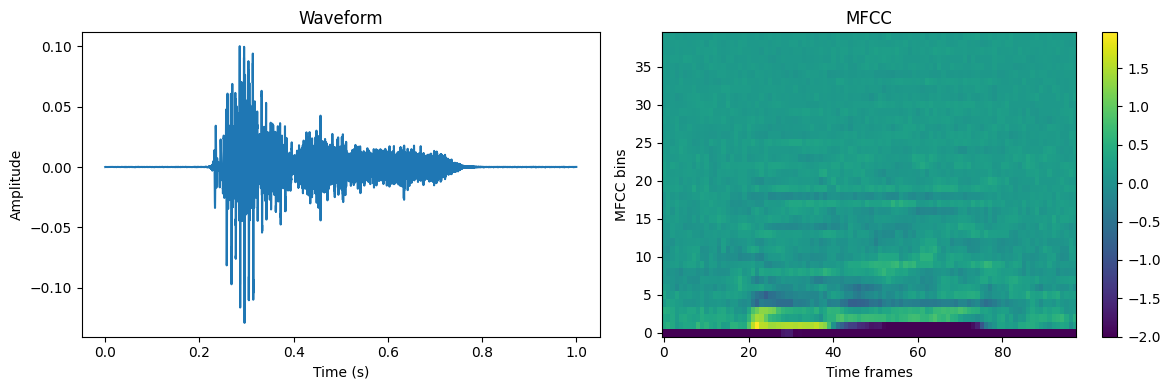

In [6]:
# Cell 6: Plot waveform and MFCC
duration = len(waveform) / SAMPLE_RATE
t = np.linspace(0, duration, len(waveform))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(t, waveform.numpy())
axes[0].set_title("Waveform")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")

im = axes[1].imshow(mfcc.numpy(), aspect="auto", origin="lower")
axes[1].set_title("MFCC")
axes[1].set_xlabel("Time frames")
axes[1].set_ylabel("MFCC bins")
fig.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

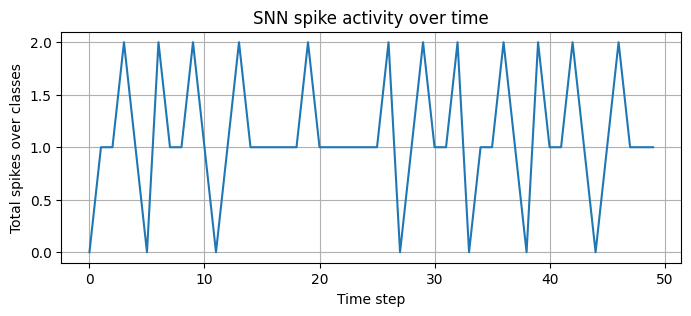

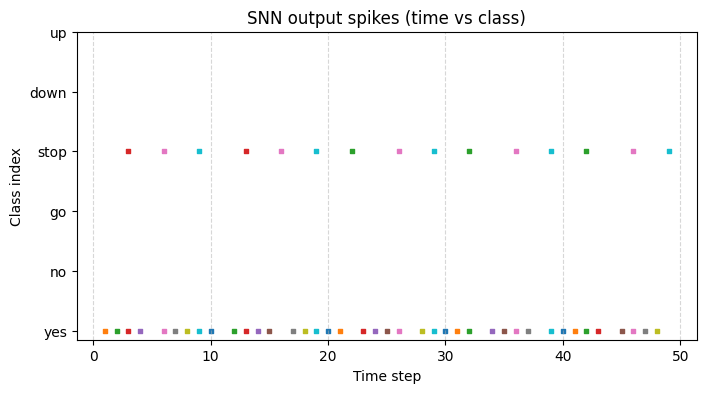

In [7]:
# Cell 7: Visualize SNN spike activity over time
with torch.no_grad():
    snn_model.num_steps = 50
    out_TBC = snn_model(mfcc_batch)

spikes = (out_TBC > 0).float().squeeze(1).cpu().numpy()
T_steps, num_classes = spikes.shape

spike_sum_t = spikes.sum(axis=1)

plt.figure(figsize=(8, 3))
plt.plot(range(T_steps), spike_sum_t)
plt.xlabel("Time step")
plt.ylabel("Total spikes over classes")
plt.title("SNN spike activity over time")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
for t_idx in range(T_steps):
    active_classes = np.where(spikes[t_idx] > 0)[0]
    plt.scatter([t_idx] * len(active_classes), active_classes, marker="s", s=10)
plt.xlabel("Time step")
plt.ylabel("Class index")
plt.title("SNN output spikes (time vs class)")
plt.yticks(range(len(CLASSES)), CLASSES)
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()